# Forecasting using regression

All aeon forecasters work by fitting on a series then making a single prediction 
about a future value. How they make the prediction defines the algorithm.

One common approach is to convert the forecasting problem into a regression problem 
through the application of a sliding window. A fixed interval is slid across the 
series to form a collection of time series. This is encapsulated in the 
`RegressionForecaster` in the `aeon.forecasting` module. We break down what is 
happening inside the forecaster before showing how to use `RegressionForecaster` to 
achieve the same effect.

<img src="img/window.png" width="600" alt="windowing">


In terms of regression, each window forms a set of explanatory variables the 
value after the window is the response. Together a window and response form a training 
case. Formatted like this, we can apply an `sklearn` tabular regressor or an `aeon` 
time series regressor. 

The response variable is the value directly after the window (if the horizon is 1). 
This is of course unknown for the last window, so we will assume that is the case we 
want to use to make a forecast.  

In [1]:
from numpy.lib.stride_tricks import sliding_window_view

from aeon.datasets import load_airline

y = load_airline()
X_train = sliding_window_view(y, window_shape=100)
X_train.shape

(45, 100)

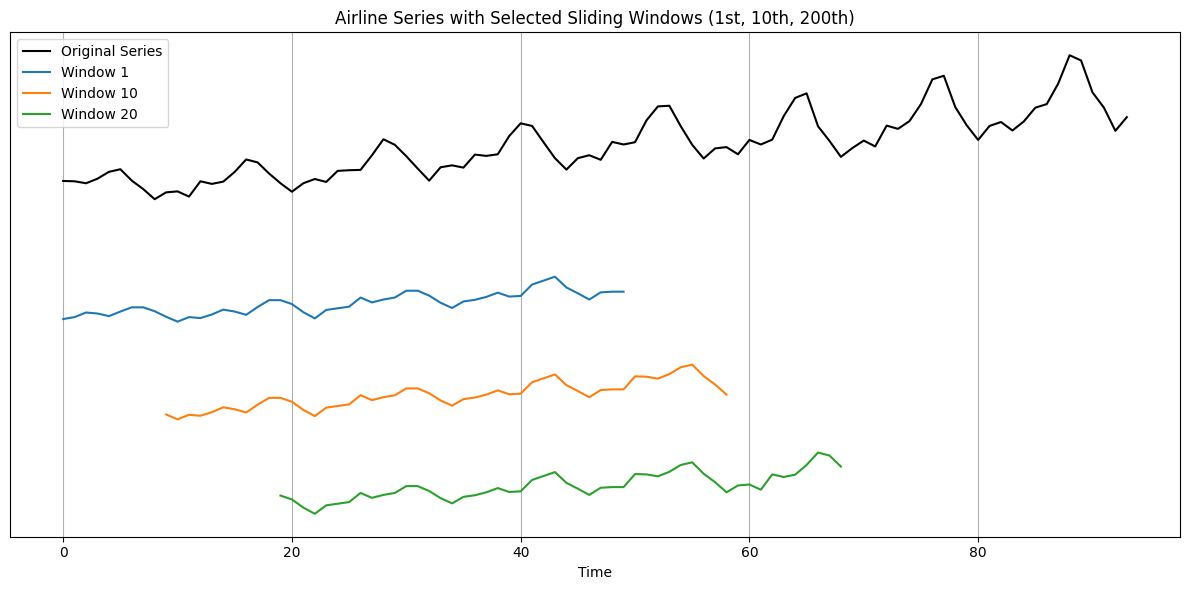

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from aeon.datasets import load_airline

# Window all the series
window = 50
X = sliding_window_view(y, window_shape=window)
X_train = X[:-1]
X_test = X[-1:]
y_train = y = y[window:]
# plot the whole series and three windows with an offset
# Plot full series
plt.figure(figsize=(12, 6))
plt.plot(y, label="Original Series", color="black")

# Vertical offset for clarity
offset = 300  # adjust depending on your data's scale
# Indices of the windows to plot
window_indices = [0, 9, 19]
# Plot selected windowed series
for idx, i in enumerate(window_indices):
    start = i
    end = i + 50
    plt.plot(
        np.arange(start, end), X_train[i] - offset * (idx + 1), label=f"Window {i+1}"
    )

# Remove y-axis
plt.gca().axes.get_yaxis().set_visible(False)

plt.legend()
plt.title("Airline Series with Selected Sliding Windows (1st, 10th, 200th)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(94, 50)
(94,)
(1, 50)


We can now build a regression model and make a prediction. This can be 
a generic `sklearn` such as `LinearRegression` or `RandomForestRegressor` or any of 
the large number of time series specific regressors in `aeon` such as `DrCIFRegressor`

In [4]:
from sklearn.linear_model import LinearRegression

from aeon.regression.interval_based import DrCIFRegressor

lr = LinearRegression()
dr = DrCIFRegressor(n_estimators=10)
lr.fit(X_train, y_train)
dr.fit(X_train, y_train)
p1 = lr.predict(X_test)
p2 = dr.predict(X_test)
print(f"LR predicts {p1} DrCIF predicts {p2}")

LR predicts [463.60934602] DrCIF predicts [413.2]


All of this goes on inside `RegressionForecaster`, which defaults to using 
`LinearRegression` with a forecasting horizon of 1. You have to pass the window 
length to use to the constructor. 

In [5]:
from aeon.datasets import load_airline
from aeon.forecasting import RegressionForecaster

airline = load_airline()
rf = RegressionForecaster(window=50)
rf.fit(airline)
p3 = rf.predict(airline)
print(f" Forecast for airline with linear regression = {p1} and {p3}")
rf2 = RegressionForecaster(regressor=DrCIFRegressor(n_estimators=10), window=50)
rf2.fit(airline)
p4 = rf.predict(airline)
print(f" Forecast for airline with DrCIF = {p1} and {p3}")

 Forecast for airline with linear regression = [463.60934602] and 463.6093460189972
 Forecast for airline with DrCIF = [463.60934602] and 463.6093460189972


You can see all the available regressors in aeon like this. They are all documented 
in the API and have examples 

In [6]:
from aeon.utils.discovery import all_estimators

all_estimators("regressor")

[('CanonicalIntervalForestRegressor',
  aeon.regression.interval_based._cif.CanonicalIntervalForestRegressor),
 ('Catch22Regressor', aeon.regression.feature_based._catch22.Catch22Regressor),
 ('DisjointCNNRegressor',
  aeon.regression.deep_learning._disjoint_cnn.DisjointCNNRegressor),
 ('DrCIFRegressor', aeon.regression.interval_based._drcif.DrCIFRegressor),
 ('DummyRegressor', aeon.regression._dummy.DummyRegressor),
 ('EncoderRegressor', aeon.regression.deep_learning._encoder.EncoderRegressor),
 ('FCNRegressor', aeon.regression.deep_learning._fcn.FCNRegressor),
 ('FreshPRINCERegressor',
  aeon.regression.feature_based._fresh_prince.FreshPRINCERegressor),
 ('HydraRegressor', aeon.regression.convolution_based._hydra.HydraRegressor),
 ('InceptionTimeRegressor',
  aeon.regression.deep_learning._inception_time.InceptionTimeRegressor),
 ('IndividualInceptionRegressor',
  aeon.regression.deep_learning._inception_time.IndividualInceptionRegressor),
 ('IndividualLITERegressor',
  aeon.regressi

All aeon forecasters predict a single value from `fit` (next forecast value from the 
train series) and from `predict` (predicted next value from test series). If you want
 to forecast a prediction horizon of values ahead you should use the functions 
 `iterative_foreacast` or `direct_forecast`. 

##     Time-Varying Parameter (TVP) Forecaster

The `aeon` RegressionForecaster defaults to fits a standard linear regression on the windowed series using the sklearn `LinearRegression` estimator. This fits the linear regression parameters with the standard least squares algorithm. An alternative approach in the forecasting literature is to fit the linear regression parameters adaptively, so that more recent observations can have a greater weight in setting the parameters. One way of doing this is to use a Kalman filter. This considers the correlation between parameters in addition to the forecasting error. This is implemented in `aeon` as the `TVPForecaster`.


In [13]:
from aeon.forecasting import TVPForecaster

tvp = TVPForecaster(window=50)
tvp.fit(y_train)
pred = tvp.predict(y_train)

 Forecast for airline with TVP = 452.44604822530795


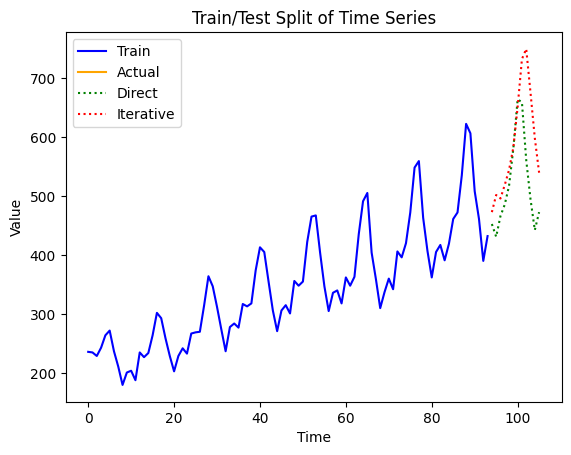

In [23]:
import matplotlib.pyplot as plt
import numpy as np

print(f" Forecast for airline with TVP = {pred}")
direct = tvp.direct_forecast(y_train, prediction_horizon=12)
iterative = tvp.iterative_forecast(y_train, prediction_horizon=12)
plt.plot(np.arange(0, len(y_train)), y_train, label="Train", color="blue")
plt.plot(
    np.arange(len(y_train), len(y_train) + len(direct)),
    direct,
    label="Direct",
    color="green",
    linestyle=":",
)
plt.plot(
    np.arange(len(y_train), len(y_train) + len(iterative)),
    iterative,
    label="Iterative",
    color="red",
    linestyle=":",
)

plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Iterative and Direct Forecasting with TVP")
plt.show()

TVP has two parameters that control the weight given to more recent observations. These are `var` and `coeff_var`. `var` represents the variation in the data. A small value of `var`, such as the default of 0.01 indicates there is less noise in the data and recent values will have a greater effect on parameter updates. It is a bit like the learning rate used in gradient descent or reinforcement learning. A large `var` value (e.g. greater than 1.0) will mean new values will adjust the parameters less at each update.

The second parameter, `beta_var`, estimates the variation in parameters over time. It has a similar effect on updates to `var` in that it effects how much parameters are changed at each stage, but it is modelling a different type on uncertainty. `TVPRegression` maintains an estimate of the covariance of the parameters in `fit` and this is adjusted after each update and then `beta_var` is added to perturb the matrix. Small `var` means the Kalman weights.

Add some examples to demonstrate the difference


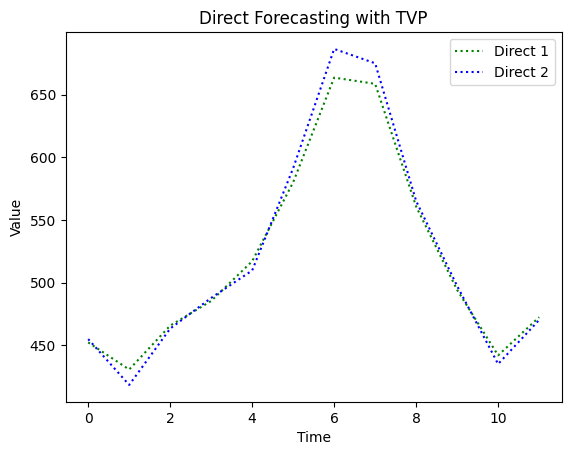

In [27]:
tvp2 = TVPForecaster(var=1.0, beta_var=1.0, window=50)
direct2 = tvp.direct_forecast(airline, prediction_horizon=12)
plt.plot(
    np.arange(0, len(direct)),
    direct,
    label="Direct 1",
    color="green",
    linestyle=":",
)
plt.plot(
    np.arange(0, len(direct2)),
    direct2,
    label="Direct 2",
    color="blue",
    linestyle=":",
)

plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Direct Forecasting with TVP")
plt.show()